In [1]:
import os
from glob import glob

import numpy as np
import uvtools as uvt
from copy import deepcopy
from pyuvdata import UVData
from pyuvdata import utils as uvutils

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches

import hera_cal as hc
import hera_sim as hs

import astropy.constants as consts
from itertools import combinations_with_replacement

In [2]:
titles = [r'Abs visibilities ($|V(\nu,t)|$)', r'Delay spectrum ($|\tilde{V}(\tau,t)|$)', r'Delay-frate spectrum ($|\tilde{V}(\tau,f)|$)']

def colorbar_plotter(fig,ax,im,label):
        
    pos = ax.get_position()
    cbarax = fig.add_axes([pos.x0 + pos.width+0.01, pos.y0, 0.008, pos.height])

    cbar = fig.colorbar(im,cax=cbarax)

    cbar.ax.tick_params(labelsize=16) 
    cbar.ax.set_ylabel(label,fontsize=16)
    
    return cbar

def auto_spectra_plotter(data,bl_ids,supertitle):
    
    fig, axs = plt.subplots(nrows=len(bl_ids),ncols=3,figsize=(25,6*len(bl_ids)))
    fig.subplots_adjust(wspace=0.35,hspace=0.2)
    fig.suptitle(supertitle,fontsize=18,y=0.94)

    nu_lst_g0, nu_lst_g1   = np.meshgrid(data.freqs/1.e6,data.lsts*12./np.pi)
    tau_lst_g0, tau_lst_g1 = np.meshgrid(data.delays,data.lsts*12./np.pi)
    tau_fr_g0, tau_fr_g1   = np.meshgrid(data.delays,data.frates)
    
    for i in range(len(bl_ids)):
        for j in range(3):
            if i==0:
                axs[i,j].set_title(titles[j],fontsize=18)
                
            if j==0:
                axim = axs[i,j].pcolormesh(nu_lst_g0, nu_lst_g1,abs(data.data[bl_ids[i]]),vmin=250,vmax=450,cmap='Spectral_r')
                axs[i,j].set_xlabel(r'$\nu\,[$MHz$]$',fontsize=14)
                axs[i,j].set_ylabel("{}\n".format(bl_ids[i]) + r'LST$\,[$h$]$',fontsize=14)
                axs[i,j].set_xlim(117.,134.)
                
            elif j==1:
                axim = axs[i,j].pcolormesh(tau_lst_g0, tau_lst_g1,np.abs(data.dlspec[bl_ids[i]]),norm=LogNorm(vmin=1.e-1,vmax=1.e4),cmap='Spectral_r')
                axs[i,j].set_xlabel(r'$\tau\,[$ns$]$',fontsize=14)
                axs[i,j].set_ylabel(r'LST$\,[$h$]$',fontsize=14)
                axs[i,j].set_xlim(-1500,1500)
                
            else:
                axim = axs[i,j].pcolormesh(tau_fr_g0, tau_fr_g1,np.abs(data.dlfrspec[bl_ids[i]]),norm=LogNorm(vmin=1.e-3,vmax=1.e6),cmap='cubehelix')
                axs[i,j].set_xlabel(r'$\tau\,[$ns$]$',fontsize=14)
                axs[i,j].set_ylabel(r'$frate\,[$mHz$]$',fontsize=14)
                axs[i,j].set_xlim(-1400,1400)
                axs[i,j].set_ylim(-5,5)
                
            axs[i,j].tick_params(axis='both',direction='in',which='both',labelsize=14)
            colorbar_plotter(fig,axs[i,j],axim,r'')

            
def cross_spectra_plotter(data,bl_ids,bl_delay,supertitle):

    arrow_tail = (130.,2.4)
    arrow_head = [(130.,2.65),(132.5,2.65),(132.5,2.4)]

    fig, axs = plt.subplots(nrows=len(bl_ids),ncols=3,figsize=(25,6*len(bl_ids)))
    fig.subplots_adjust(wspace=0.35,hspace=0.2)
    fig.suptitle(supertitle,fontsize=18,y=0.93)

    nu_lst_g0, nu_lst_g1   = np.meshgrid(data.freqs/1.e6,data.lsts*12./np.pi)
    tau_lst_g0, tau_lst_g1 = np.meshgrid(data.delays,data.lsts*12./np.pi)
    tau_fr_g0, tau_fr_g1   = np.meshgrid(data.delays,data.frates)
    
    for i in range(len(bl_ids)):
        for j in range(3):
            if i==0:
                axs[i,j].set_title(titles[j],fontsize=18)
                
            if j==0:
                axim = axs[i,j].pcolormesh(nu_lst_g0, nu_lst_g1,abs(data.data[bl_ids[i]]),vmin=0,vmax=25,cmap='Spectral_r')
                axs[i,j].set_xlabel(r'$\nu\,[$MHz$]$',fontsize=14)
                axs[i,j].set_ylabel("{}\n".format(bl_ids[i]) + r'LST$\,[$h$]$',fontsize=14)
                
                arrow = mpatches.FancyArrowPatch(arrow_tail, arrow_head[i], mutation_scale=10)
                axs[i,j].add_patch(arrow)
                                
            elif j==1:
                axim = axs[i,j].pcolormesh(tau_lst_g0, tau_lst_g1,np.abs(data.dlspec[bl_ids[i]]),norm=LogNorm(vmin=1.e-3,vmax=1.e3),cmap='Spectral_r')
                axs[i,j].axvline(bl_delay[i],c='k',ls='--',lw=2)
                axs[i,j].axvline(-1.*bl_delay[i],c='k',ls='--',lw=2)
                axs[i,j].set_xlabel(r'$\tau\,[$ns$]$',fontsize=14)
                axs[i,j].set_ylabel(r'LST$\,[$h$]$',fontsize=14)
                axs[i,j].set_xlim(-1500,1500)
                
            else:
                axim = axs[i,j].pcolormesh(tau_fr_g0, tau_fr_g1,np.abs(data.dlfrspec[bl_ids[i]]),norm=LogNorm(vmin=1.e-3,vmax=1.e5),cmap='cubehelix')
                axs[i,j].axvline(bl_delay[i],c='w',ls='--',lw=2)
                axs[i,j].axvline(-1.*bl_delay[i],c='w',ls='--',lw=2)
                axs[i,j].set_xlabel(r'$\tau\,[$ns$]$',fontsize=14)
                axs[i,j].set_ylabel(r'$frate\,[$mHz$]$',fontsize=14)
                axs[i,j].set_xlim(-1400,1400)
                axs[i,j].set_ylim(-5,5)
                
            axs[i,j].tick_params(axis='both',direction='in',which='both',labelsize=14)
            colorbar_plotter(fig,axs[i,j],axim,r'')

def delayspec_slice_plotter(data1,data2,data3,bl_ids,horizon,lst_slice,lst_idx,suptitle,vmin,vmax):
    
    fig, axs = plt.subplots(nrows=len(bl_ids),ncols=3,figsize=(24,5*len(bl_ids)))
    fig.subplots_adjust(wspace=0.15,hspace=0.1)
    fig.suptitle(suptitle,fontsize=18)

    tau = data1.delays
    
    arrow_tail = (500.,1.e1)
    arrow_head = [(500.,1.e3),(1000.,1.e3),(1000.,1.e1)]
    
    for i in range(len(bl_ids)):
        for j in range(3):
            axs[i,j].semilogy(tau,abs(data1.dlspec[bl_ids[i]][lst_idx[j],:]),c='r',lw=2,label=r'X-coupling (3-ants)')
            axs[i,j].semilogy(tau,abs(data2.dlspec[bl_ids[i]][lst_idx[j],:]),c='b',lw=2,label=r'X-coupling (1-ant)')
            axs[i,j].semilogy(tau,abs(data3.dlspec[bl_ids[i]][lst_idx[j],:]),c='k',lw=2,label=r'No X-coupling') 

            axs[i,j].set_xlim(-1400.,1400.)
            axs[i,j].grid(lw=0.8,ls=':',c='gray')
            axs[i,j].set_ylim(vmin,vmax)
            
            if horizon is not None:
                axs[i,j].axvline(horizon[i],c='k',ls='--',lw=2)
                axs[i,j].axvline(-1.*horizon[i],c='k',ls='--',lw=2)
                arrow = mpatches.FancyArrowPatch(arrow_tail, arrow_head[i], mutation_scale=18)
                axs[i,j].add_patch(arrow)
                
            
            if i==2:
                axs[i,j].set_xlabel(r'$\tau\,[$ns$]$',fontsize=16)  
                axs[i,j].tick_params(axis='both',direction='in',which='both',labelsize=14)
            elif i==0:
                axs[i,j].set_title(r'LST = %.1f h'%(lst_slice[j]),fontsize=16)
                axs[i,j].tick_params(axis='both',which='both',direction='in',labelbottom=False,labelsize=14)
            else:
                axs[i,j].tick_params(axis='both',which='both',direction='in',labelbottom=False,labelsize=14)
            
            if j==0:
                axs[i,j].set_ylabel("{}\n".format(bl_ids[i])+ r'$[$Jy Hz$]$',fontsize=16)
                
    handles, labels = axs[0,1].get_legend_handles_labels()
    axs[0,1].legend(handles,labels,fontsize=16,ncol=3,loc='upper left',bbox_to_anchor=(-0.4,1.3))
            
def nearest_idx(data,val):
    return np.abs(data - val).argmin()

Text(0, 0.5, 'y-direction--> $[$m$]$')

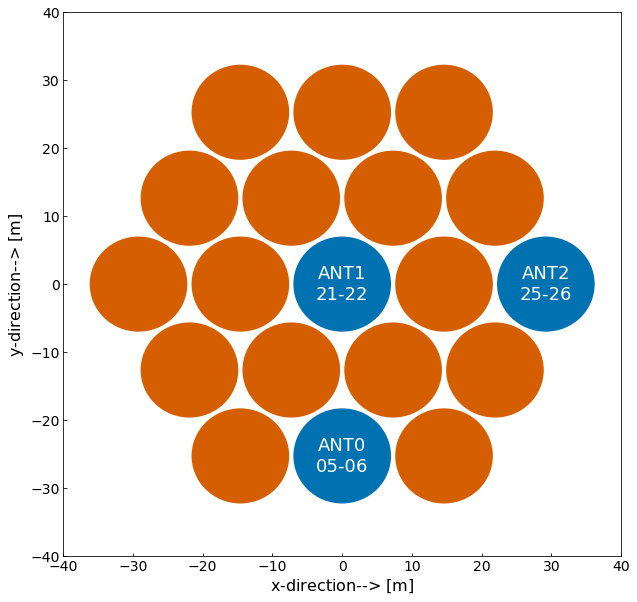

In [3]:
ant_pos = np.loadtxt('HERA_positions/antenna_positions_19.dat')[:,:-1]
ant_id = [9,11,17]

ant_pos = ant_pos -  ant_pos[9,:][np.newaxis,:]

ant_name = ['ANT1\n21-22','ANT2\n25-26','ANT0\n05-06']
colors = ["#D55E00", "#0072B2"]

fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(10,10))
j=0
for i in range(ant_pos.shape[0]):
    if (i in ant_id):
        ant = plt.Circle((ant_pos[i,0],ant_pos[i,1]),7.,facecolor=colors[1])
        plt.text(ant_pos[i,0],ant_pos[i,1],ant_name[j],horizontalalignment='center',
                 verticalalignment='center',multialignment='center',fontsize=18,color='white') 
        
        j+=1
    else:
        ant = plt.Circle((ant_pos[i,0],ant_pos[i,1]),7.,facecolor=colors[0])

    axs.add_artist(ant)

axs.set_xlim(-40.,40.)
axs.set_ylim(-40.,40.)

axs.tick_params(axis='both',direction='in',which='both',labelsize=14)

axs.set_xlabel(r'x-direction--> $[$m$]$',fontsize=16)
axs.set_ylabel(r'y-direction--> $[$m$]$',fontsize=16)

In [4]:
#Read data

cc3_data = hc.io.HERAData('/data7/pyuvsim_results/Cross-coupling-beam-sims/results/HERA_cc-3ant_GLEAM_Scut-100mJy_115-134MHz_90min.uvh5')
cc3_data.read()
cc3_data = hc.vis_clean.VisClean(cc3_data)

cc1_data = hc.io.HERAData('/data7/pyuvsim_results/Cross-coupling-beam-sims/results/HERA_single-cc-3ant_GLEAM_Scut-100mJy_115-134MHz_90min.uvh5')
cc1_data.read()
cc1_data = hc.vis_clean.VisClean(cc1_data)

legacy_data = hc.io.HERAData('/data7/pyuvsim_results/Cross-coupling-beam-sims/results/HERA_no-cc-3ant_GLEAM_Scut-100mJy_115-134MHz_90min.uvh5')
legacy_data.read()
legacy_data = hc.vis_clean.VisClean(legacy_data)

In [5]:
#Calculate delay spectrum and fringe rate spectrum of data

cc3_data.fft_data(cc3_data.data, window='bh', ax='freq',assign='dlspec',overwrite=True)
cc3_data.fft_data(cc3_data.data, window='bh', ax='time',assign='frspec',overwrite=True)
cc3_data.fft_data(cc3_data.data, window='bh', ax='both',assign='dlfrspec',overwrite=True)

cc1_data.fft_data(cc1_data.data, window='bh', ax='freq',assign='dlspec',overwrite=True)
cc1_data.fft_data(cc1_data.data, window='bh', ax='time',assign='frspec',overwrite=True)
cc1_data.fft_data(cc1_data.data, window='bh', ax='both',assign='dlfrspec',overwrite=True)

legacy_data.fft_data(legacy_data.data, window='bh', ax='freq',assign='dlspec',overwrite=True)
legacy_data.fft_data(legacy_data.data, window='bh', ax='time',assign='frspec',overwrite=True)
legacy_data.fft_data(legacy_data.data, window='bh', ax='both',assign='dlfrspec',overwrite=True)

In [6]:
auto_list=[]
cross_list=[]
bl_length = []

for k in range(2):
    for i in range(3):
        if k==0:
            auto_list.append((i,i,'xx'))
        else:
            auto_list.append((i,i,'yy'))
        for j in range(0,i):
            if i!=j:
                if k==0:
                    cross_list.append((i,j,'xx'))
                else:
                    cross_list.append((i,j,'yy'))
                bl_length.append(cc3_data.bllens[(i,j)]*1.e9)

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


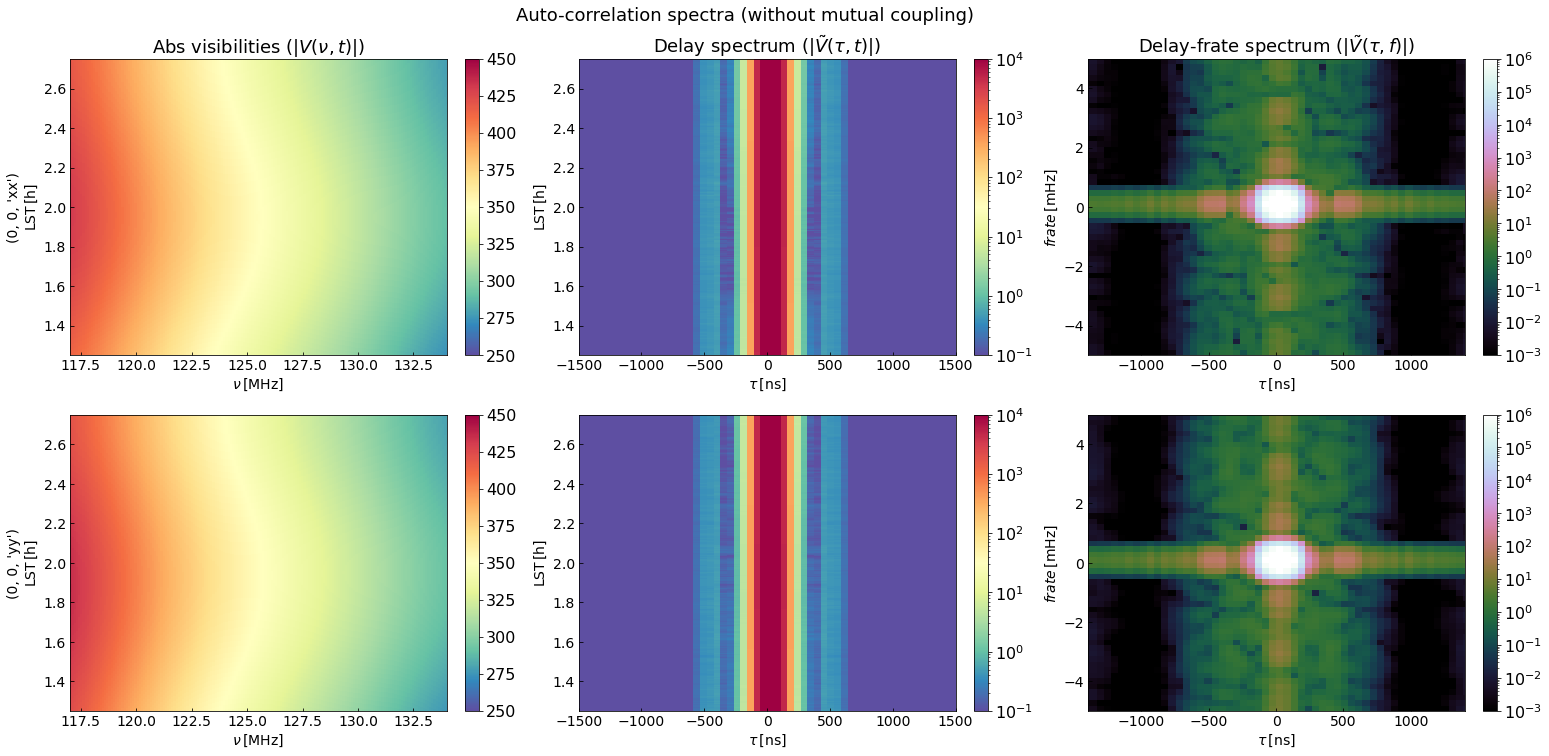

In [7]:
#plot auto spectra without cross-coupling
auto_spectra_plotter(legacy_data,[auto_list[0],auto_list[3]],'Auto-correlation spectra (without mutual coupling)')

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


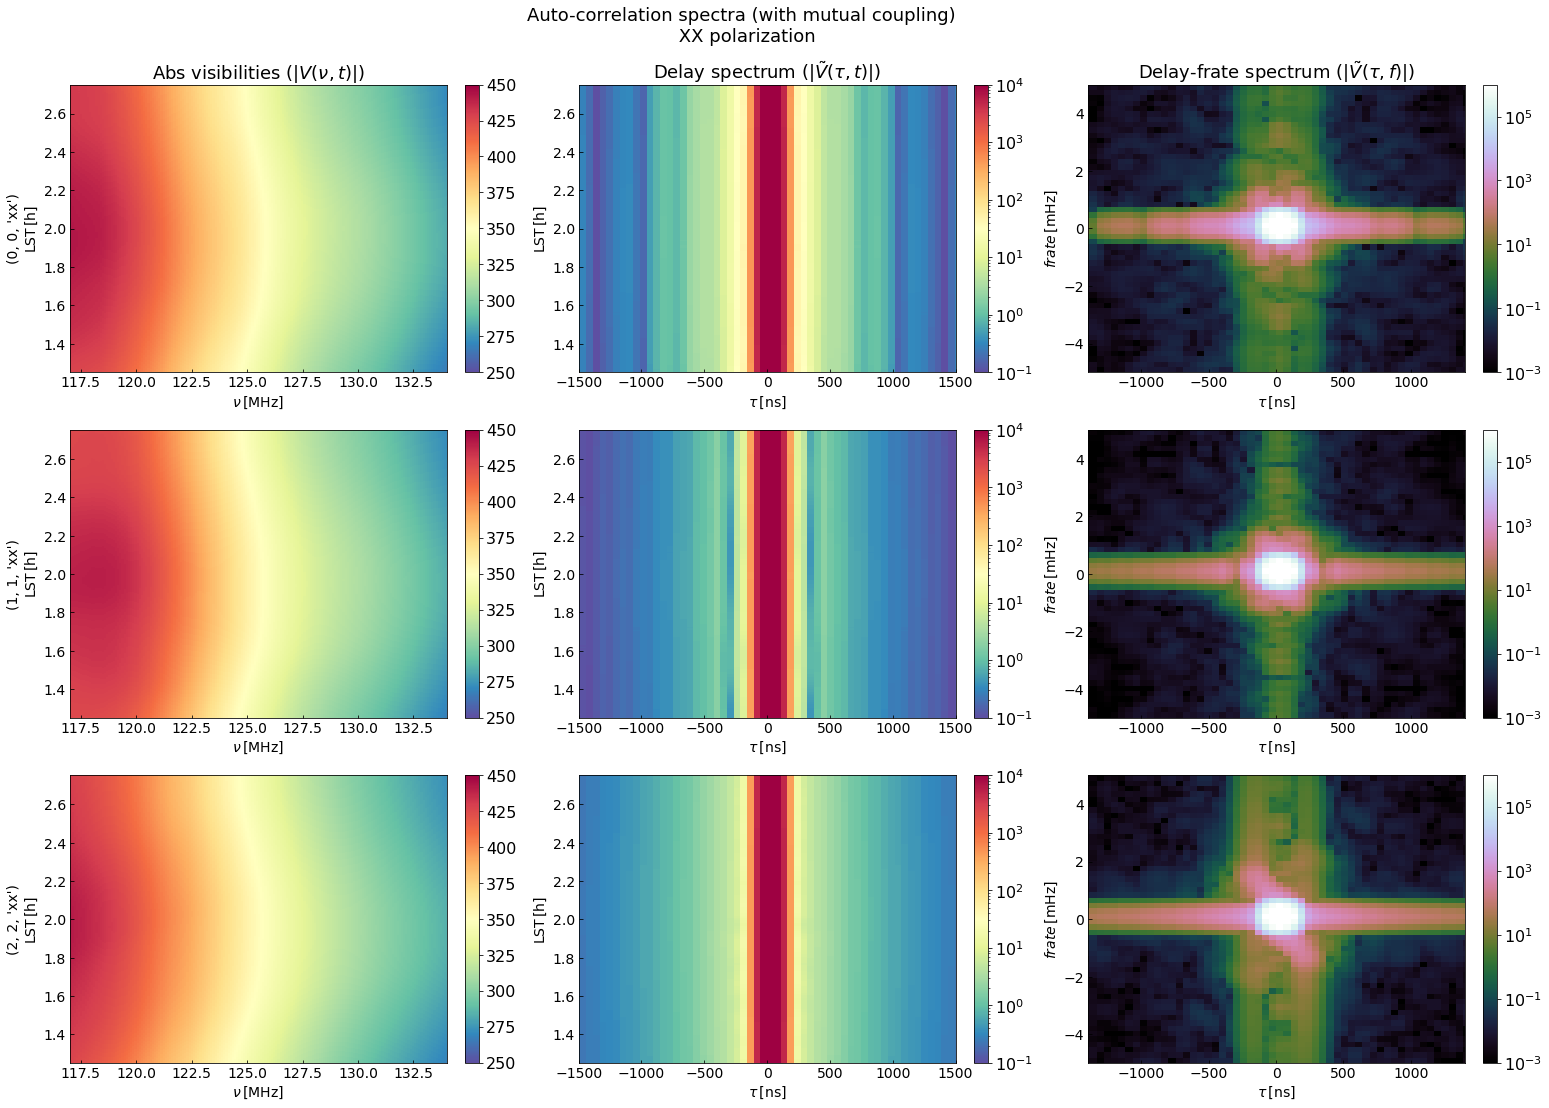

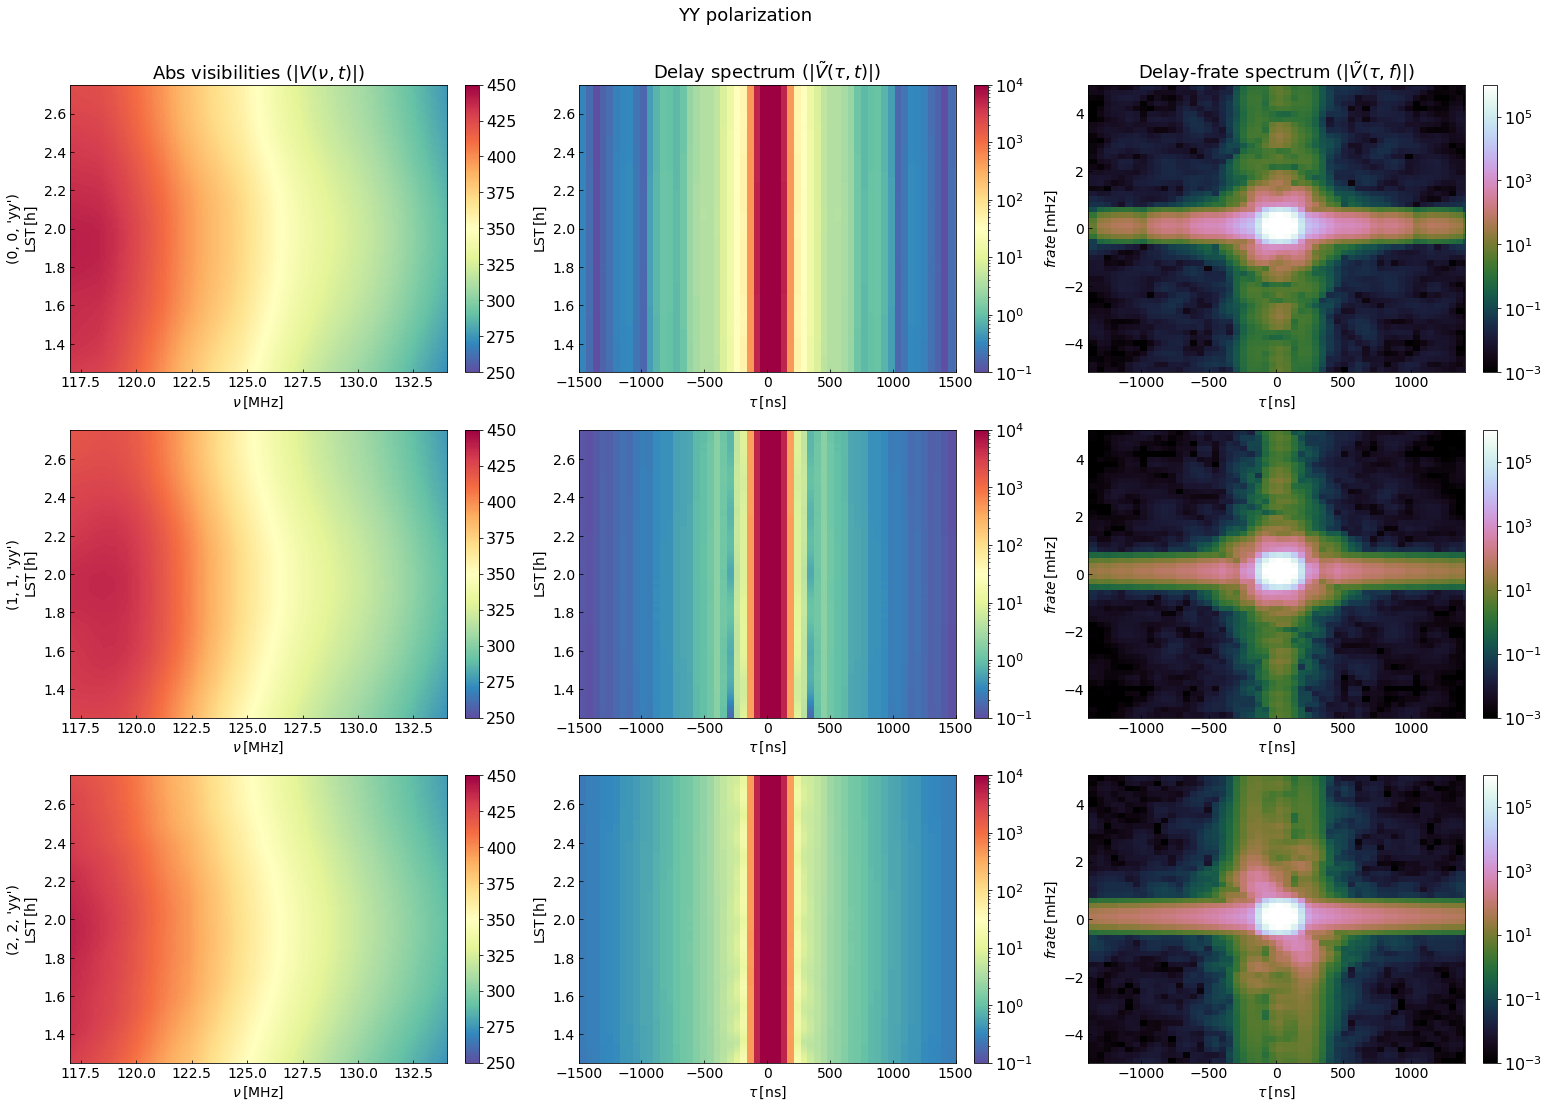

In [8]:
#auto-spectra with cross-coupling beams
auto_spectra_plotter(cc3_data,auto_list[:3],'Auto-correlation spectra (with mutual coupling) \n XX polarization')
auto_spectra_plotter(cc3_data,auto_list[3:],'YY polarization')

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


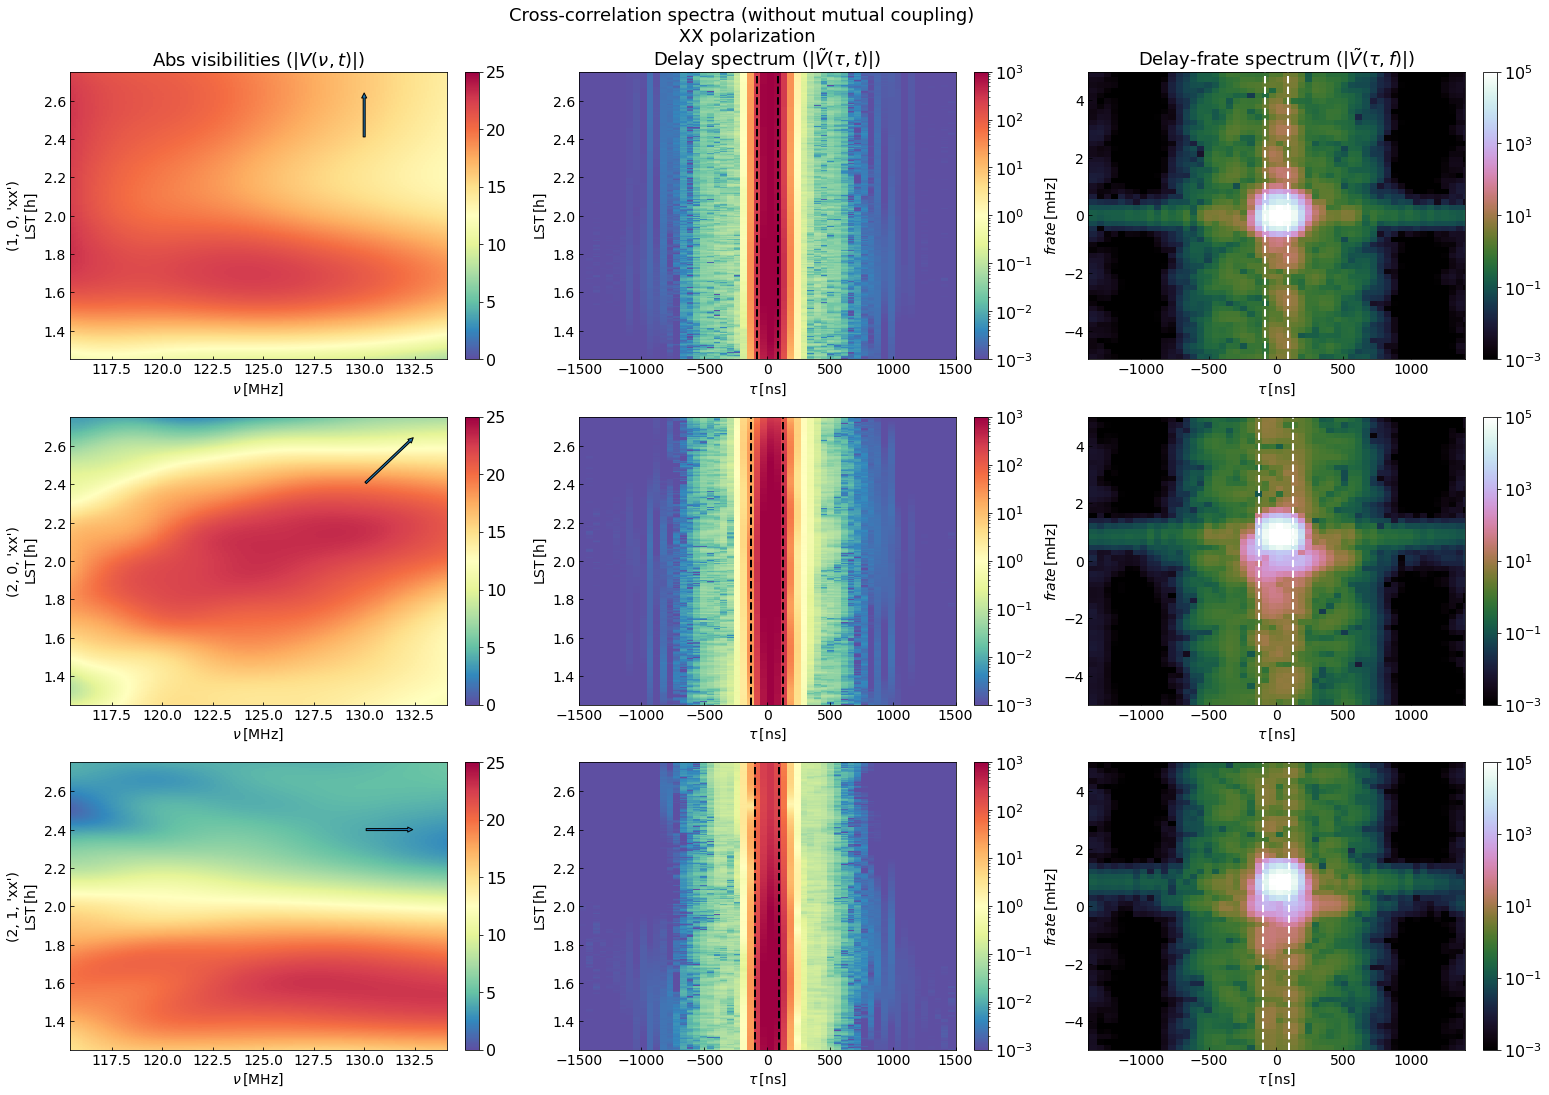

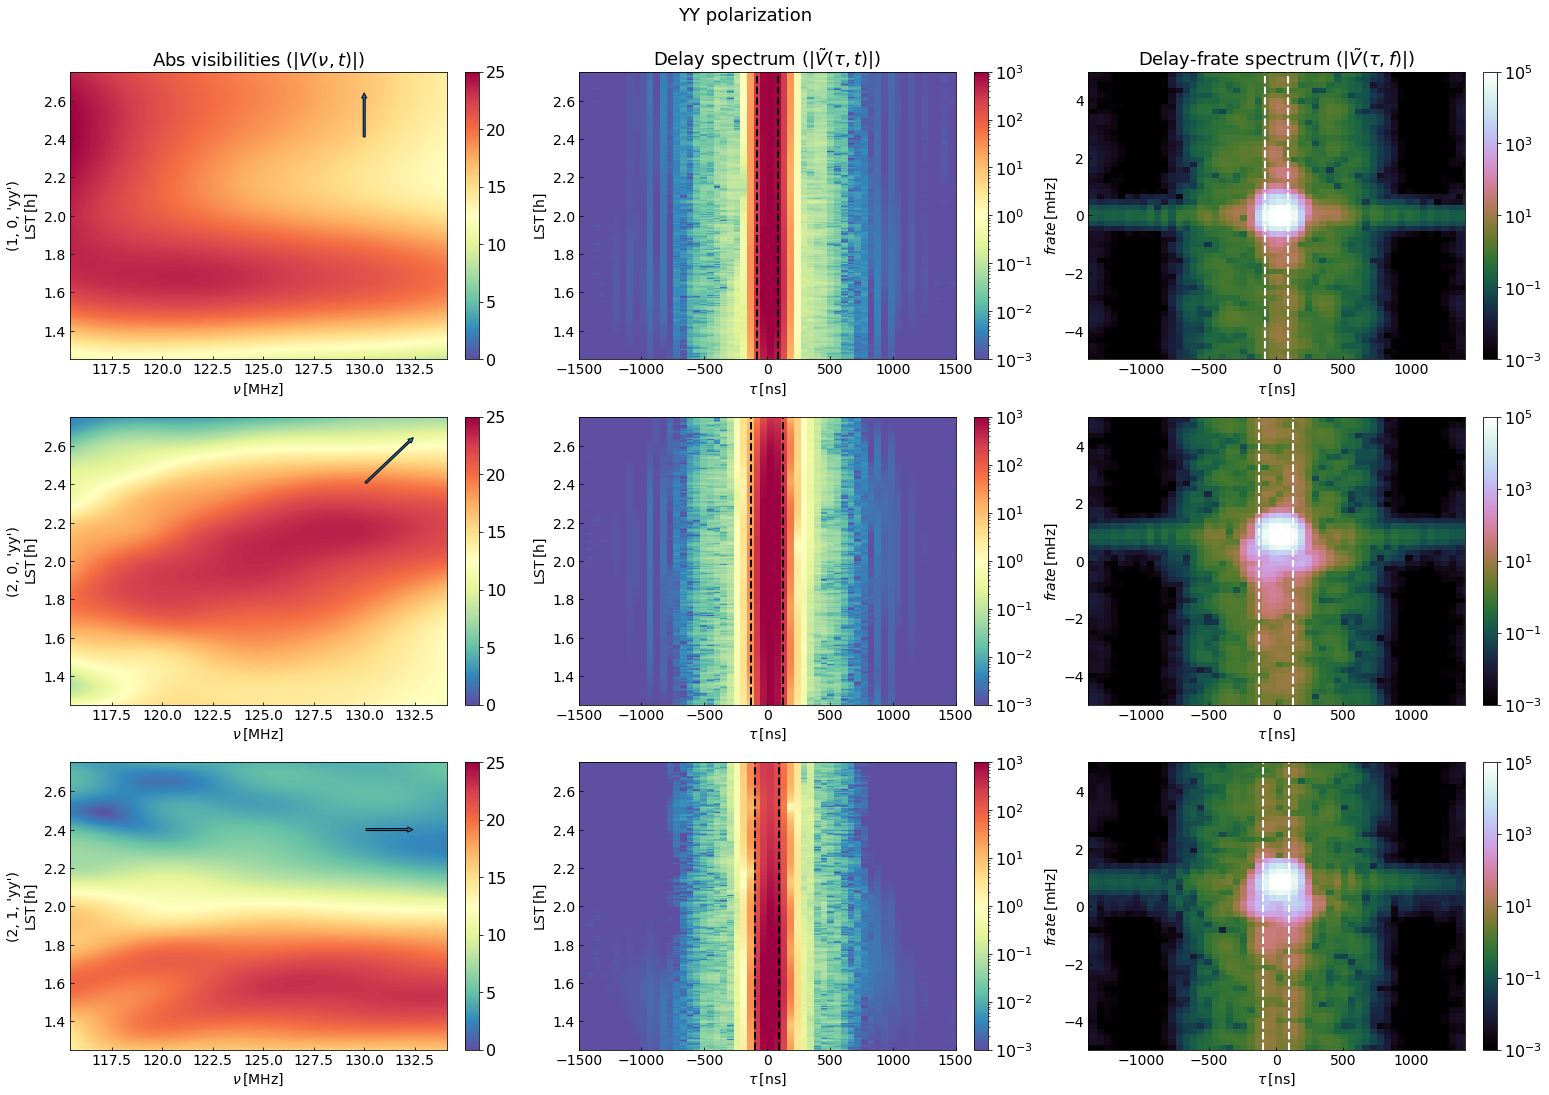

In [9]:
#Cross-correlation spectra without mutual coupling
cross_spectra_plotter(legacy_data,cross_list[:3],bl_length,'Cross-correlation spectra (without mutual coupling) \n XX polarization')
cross_spectra_plotter(legacy_data,cross_list[3:],bl_length,'YY polarization')

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


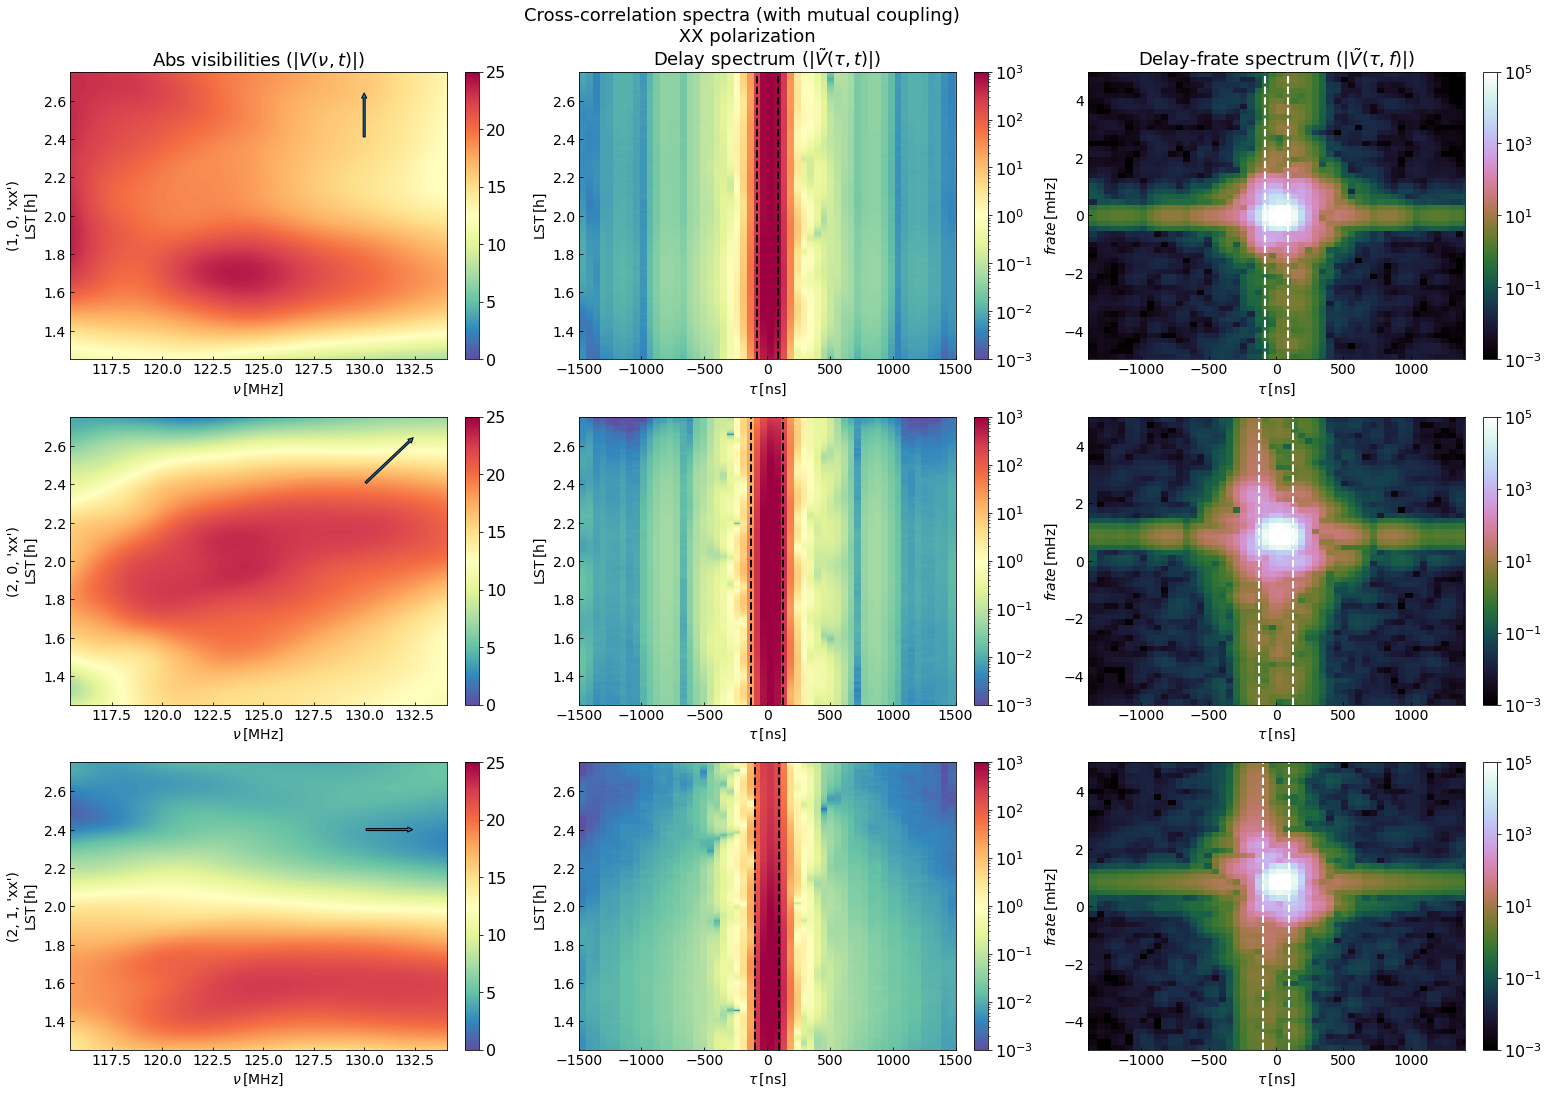

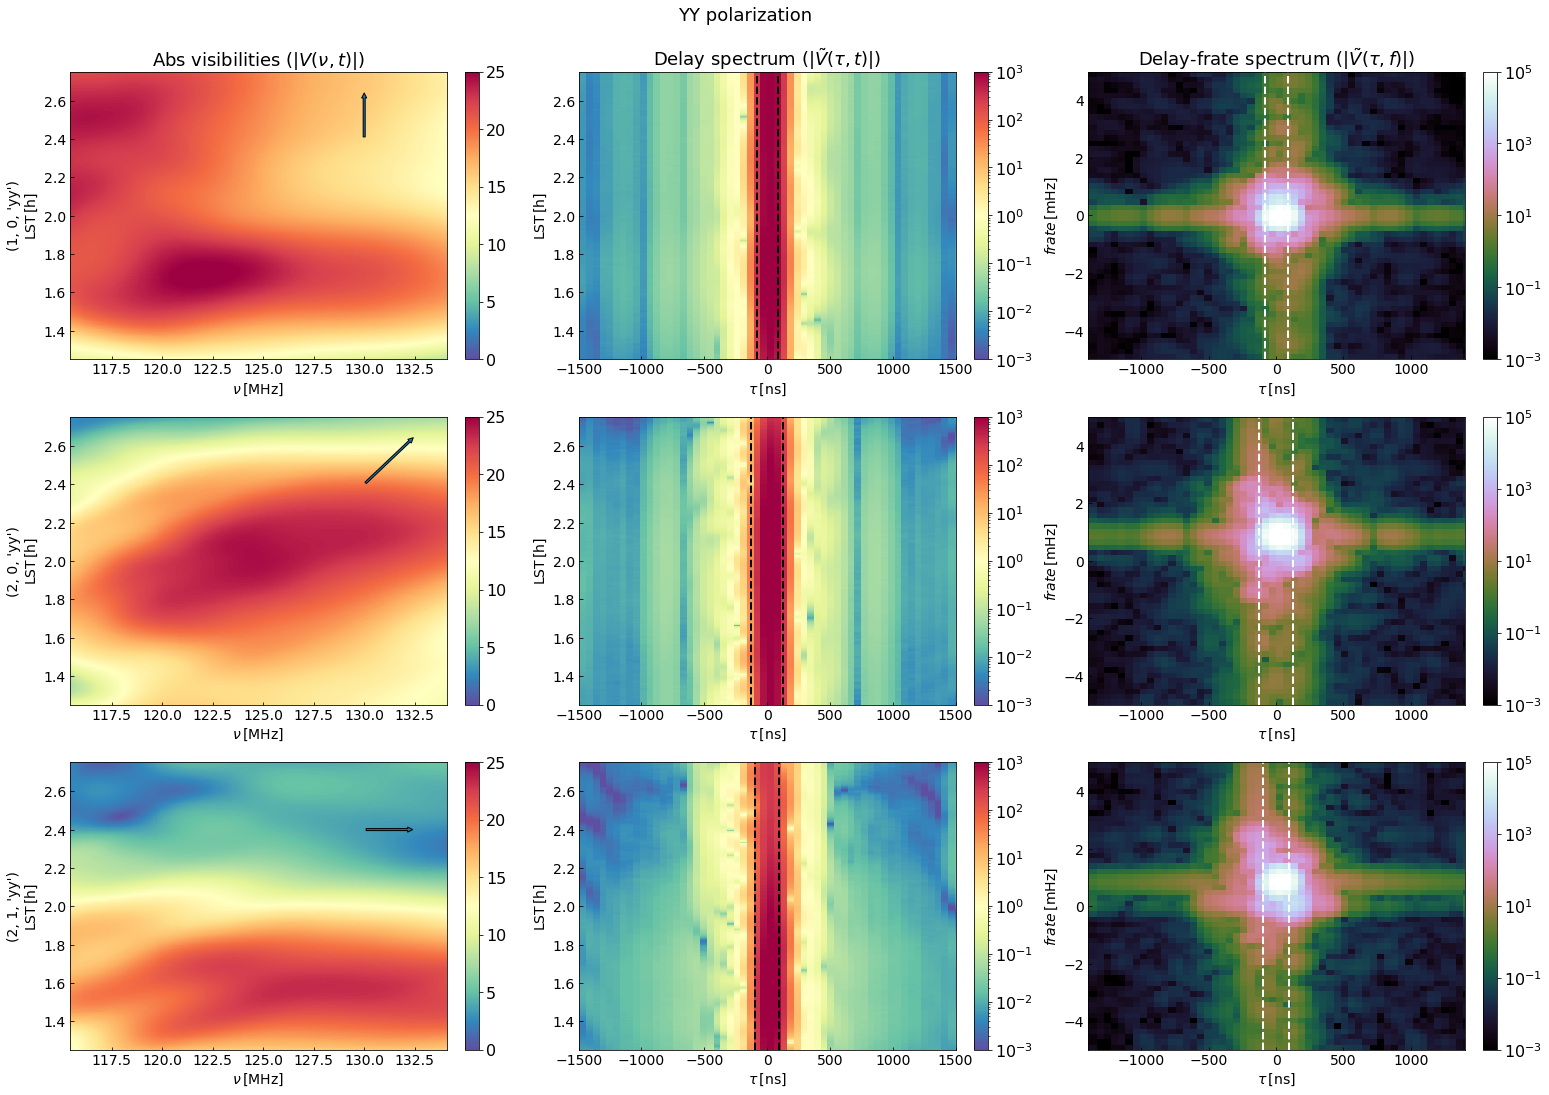

In [10]:
# cross-correlation spectra with mutual coupling
cross_spectra_plotter(cc3_data,cross_list[:3],bl_length,'Cross-correlation spectra (with mutual coupling) \n XX polarization')
cross_spectra_plotter(cc3_data,cross_list[3:],bl_length,'YY polarization')

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


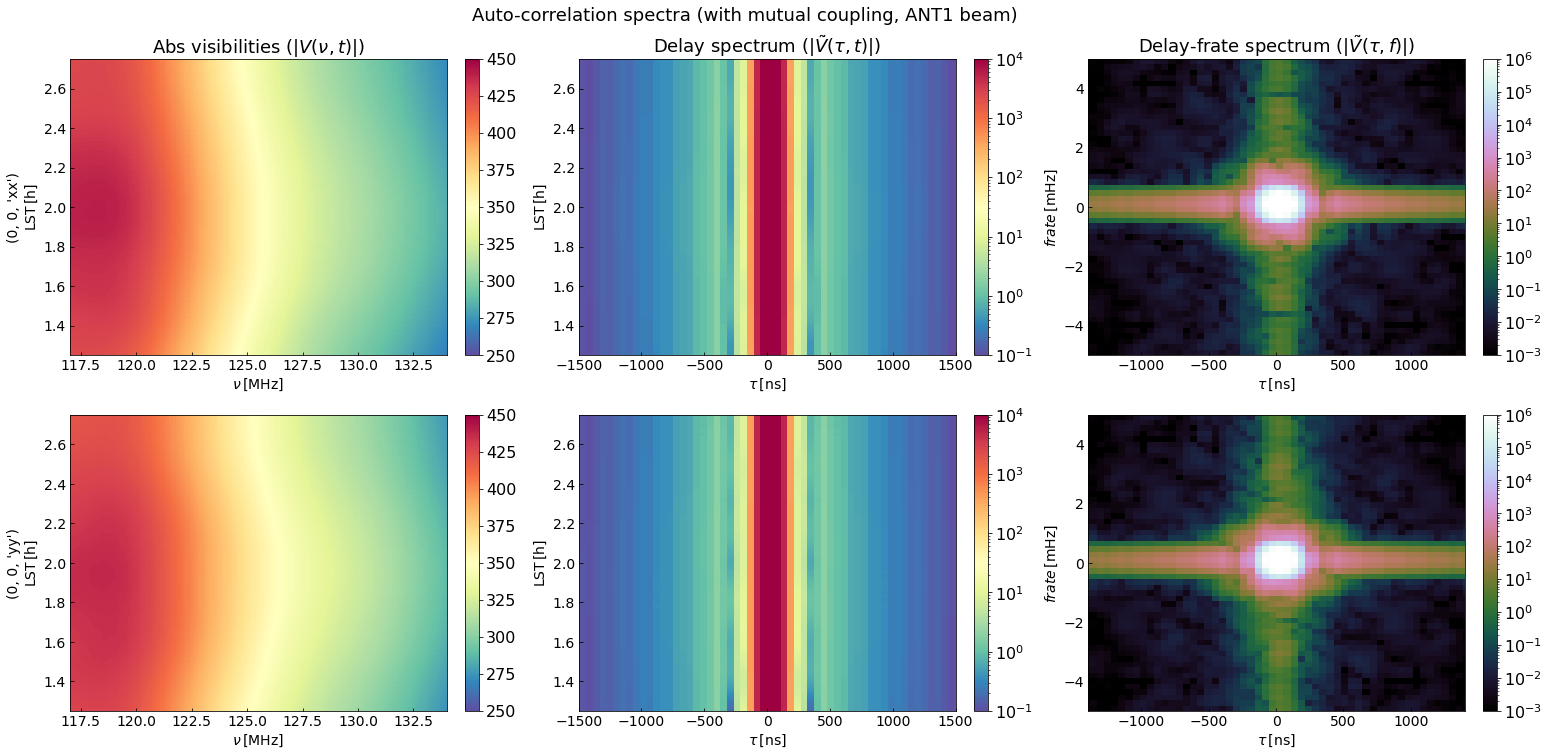

In [11]:
auto_spectra_plotter(cc1_data,[auto_list[0],auto_list[3]],'Auto-correlation spectra (with mutual coupling, ANT1 beam)')

shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


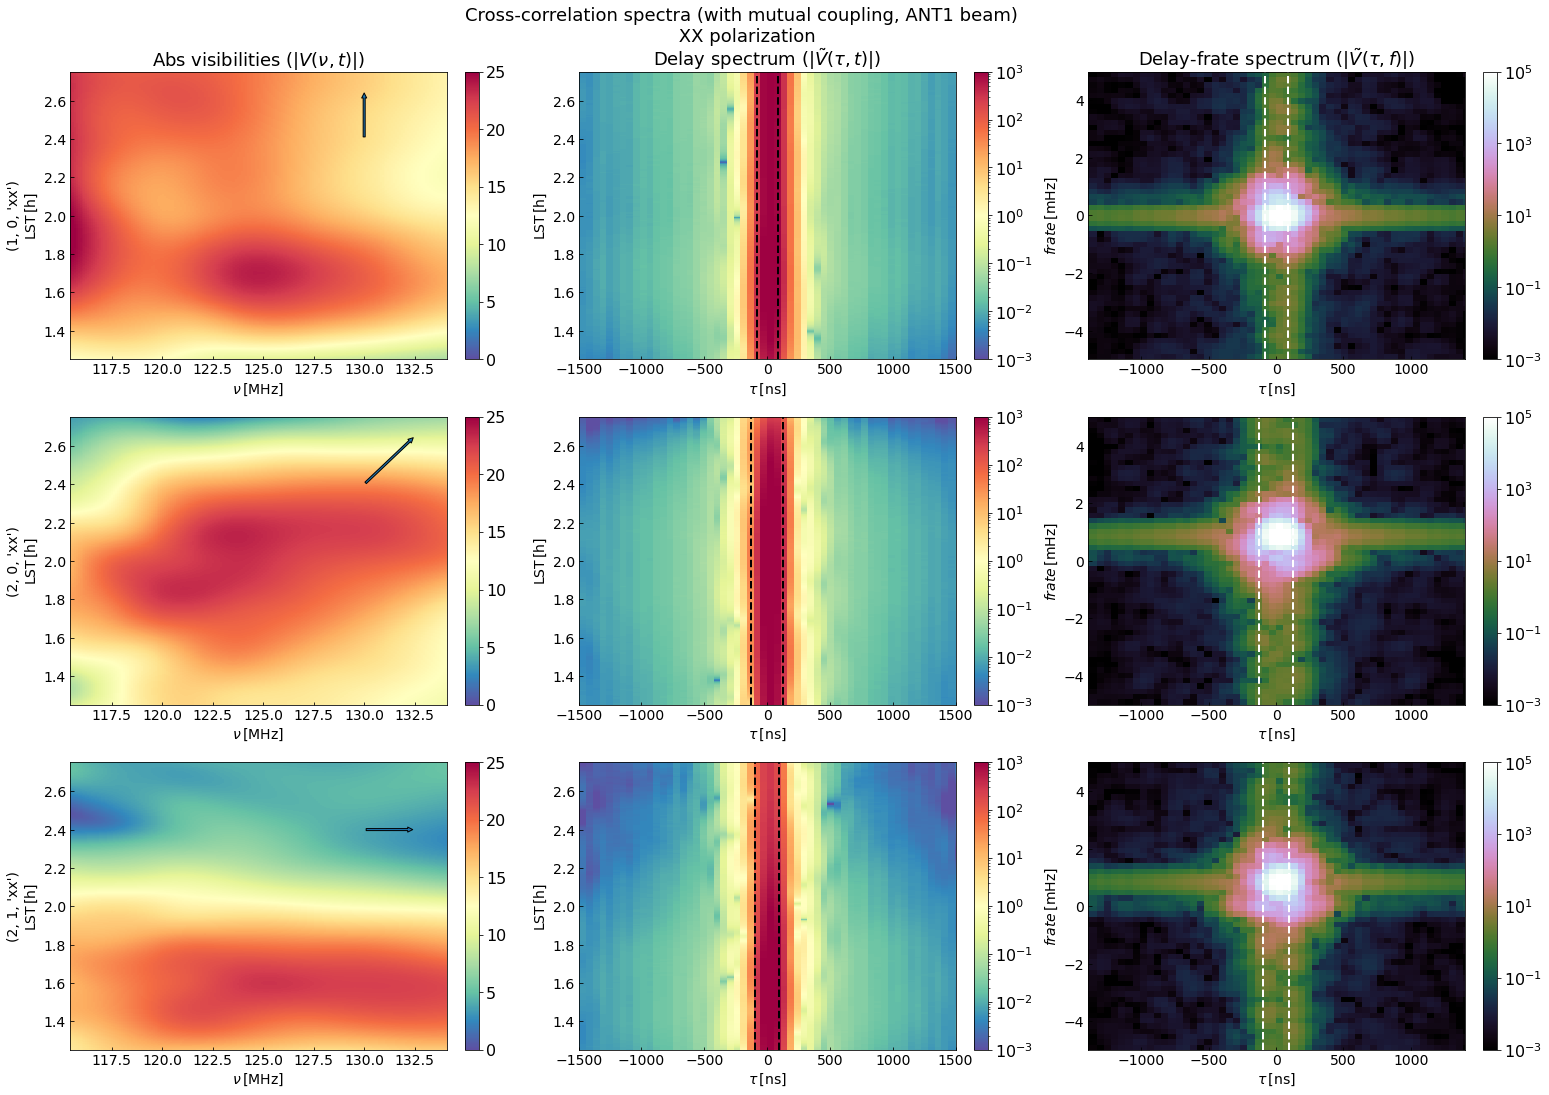

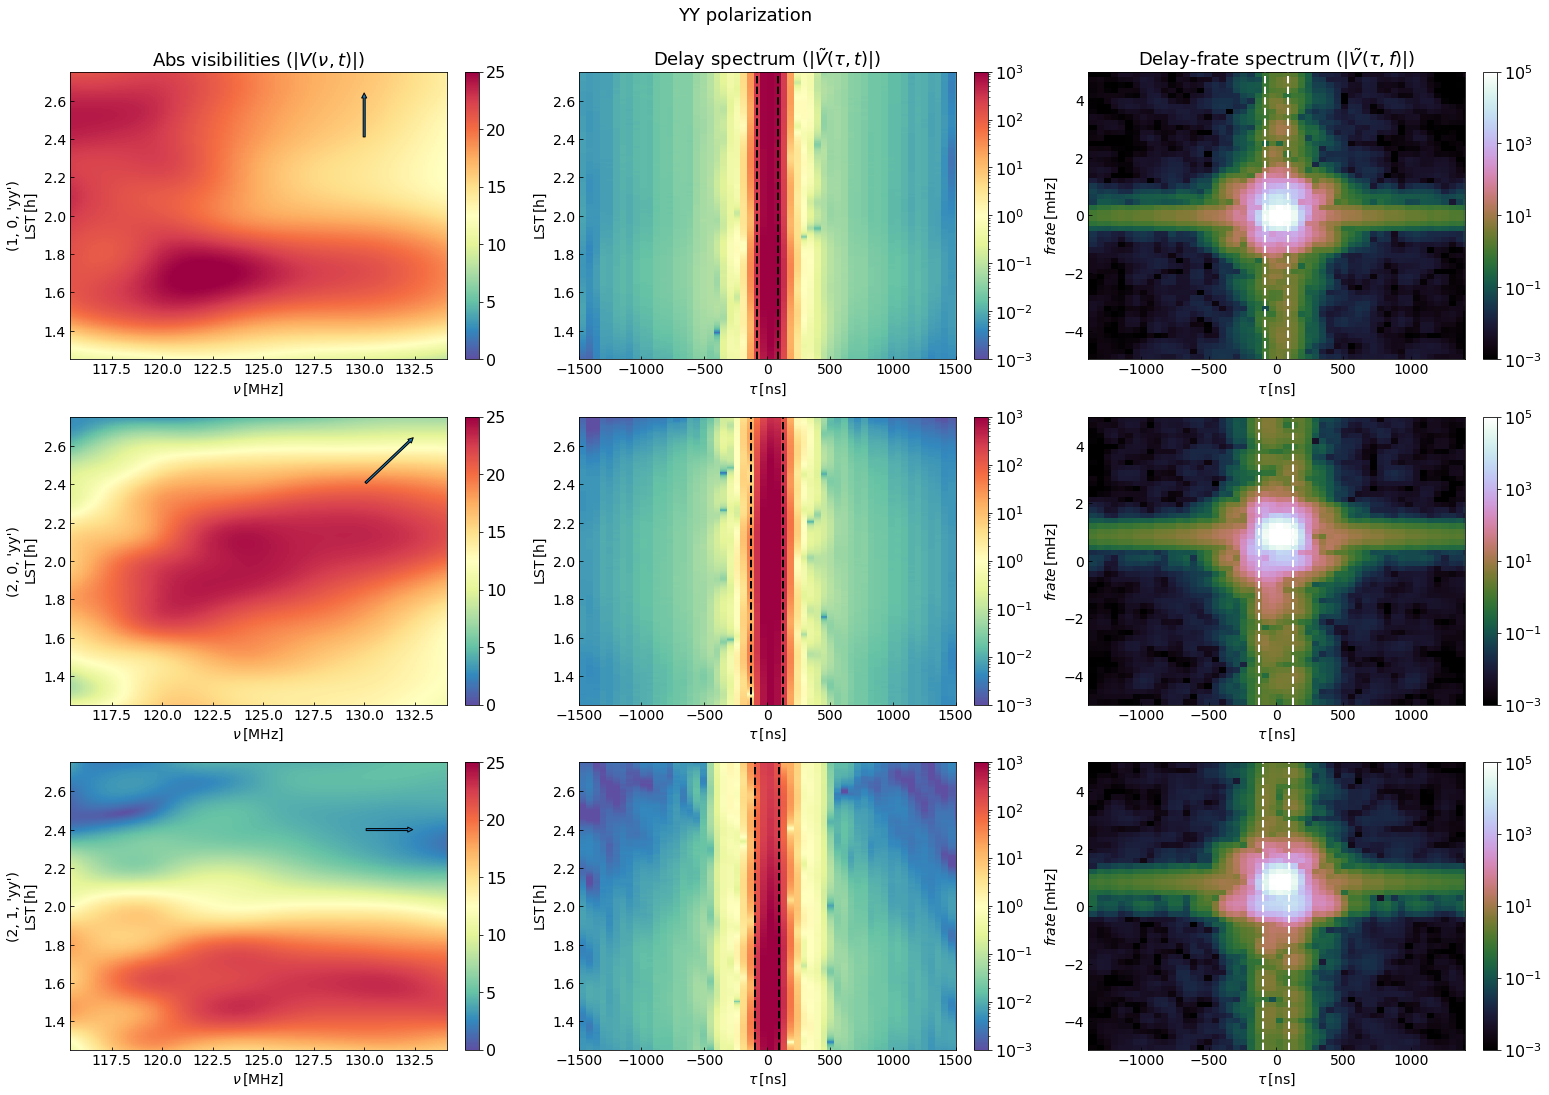

In [12]:
# cross-correlation spectra with mutual coupling, ANT1 beam
cross_spectra_plotter(cc1_data,cross_list[:3],bl_length,'Cross-correlation spectra (with mutual coupling, ANT1 beam) \n XX polarization')
cross_spectra_plotter(cc1_data,cross_list[3:],bl_length,'YY polarization')

In [13]:
lsts = cc3_data.lsts
lst_slice = np.array([1.4,2.0,2.6])

lst_idx = [nearest_idx(lsts*12./np.pi,lst_slice[0]),
           nearest_idx(lsts*12./np.pi,lst_slice[1]),
           nearest_idx(lsts*12./np.pi,lst_slice[2])]

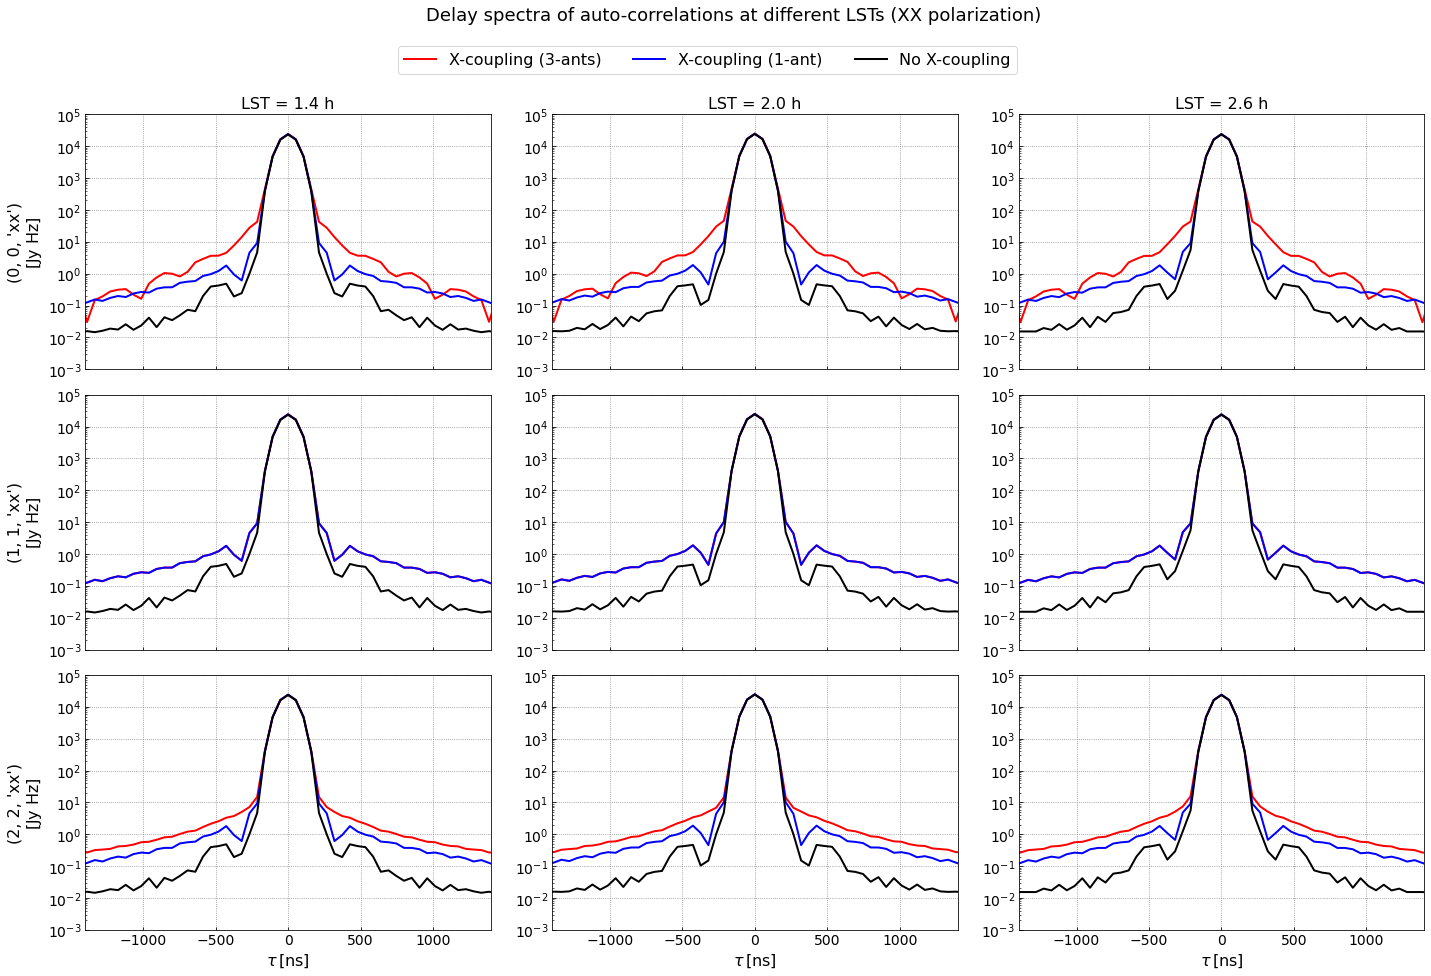

In [14]:
delayspec_slice_plotter(cc3_data,cc1_data,legacy_data,auto_list[:3],None,lst_slice,lst_idx,
                        r'Delay spectra of auto-correlations at different LSTs (XX polarization)',1.e-3,1.e5)

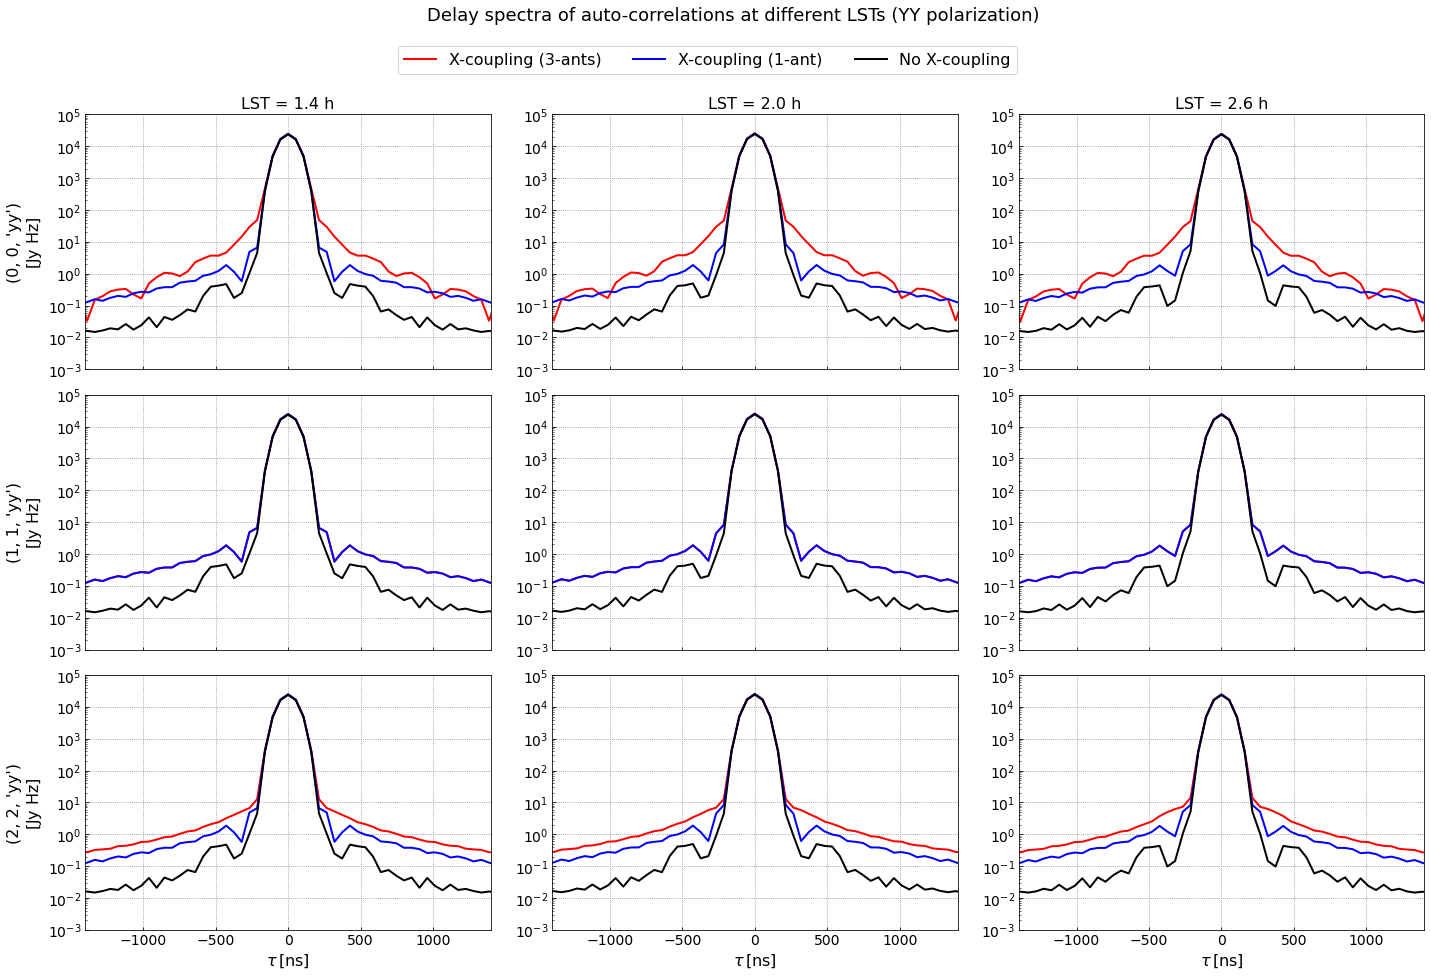

In [15]:
delayspec_slice_plotter(cc3_data,cc1_data,legacy_data,auto_list[3:],None,lst_slice,lst_idx,
                        r'Delay spectra of auto-correlations at different LSTs (YY polarization)',1.e-3,1.e5)

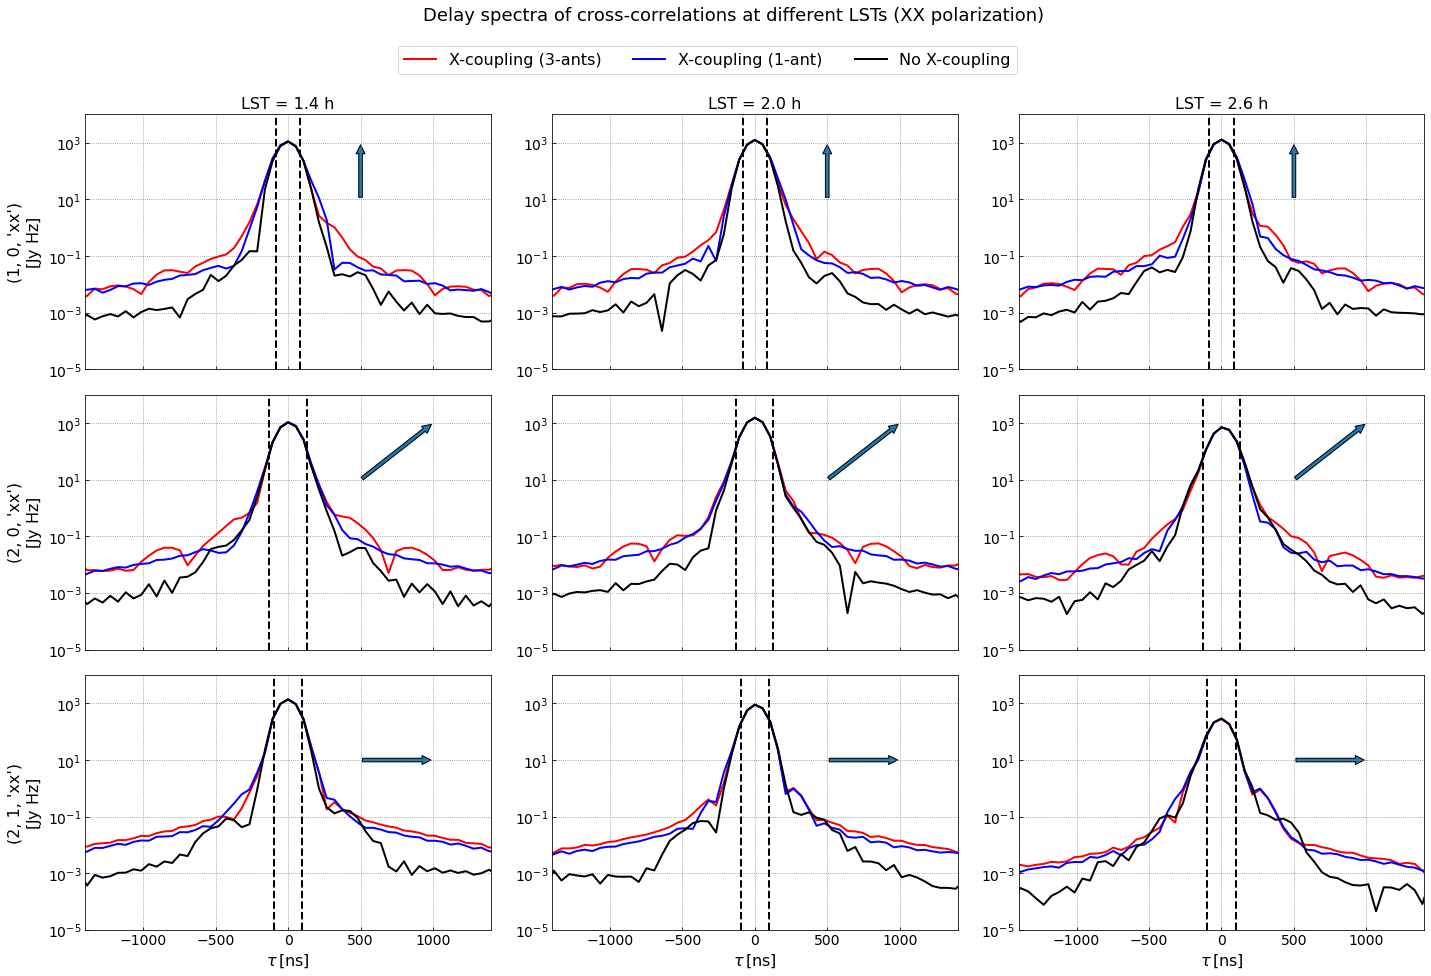

In [16]:
delayspec_slice_plotter(cc3_data,cc1_data,legacy_data,cross_list[:3],bl_length[:3],lst_slice,lst_idx,
                        r'Delay spectra of cross-correlations at different LSTs (XX polarization)',1.e-5,1.e4)

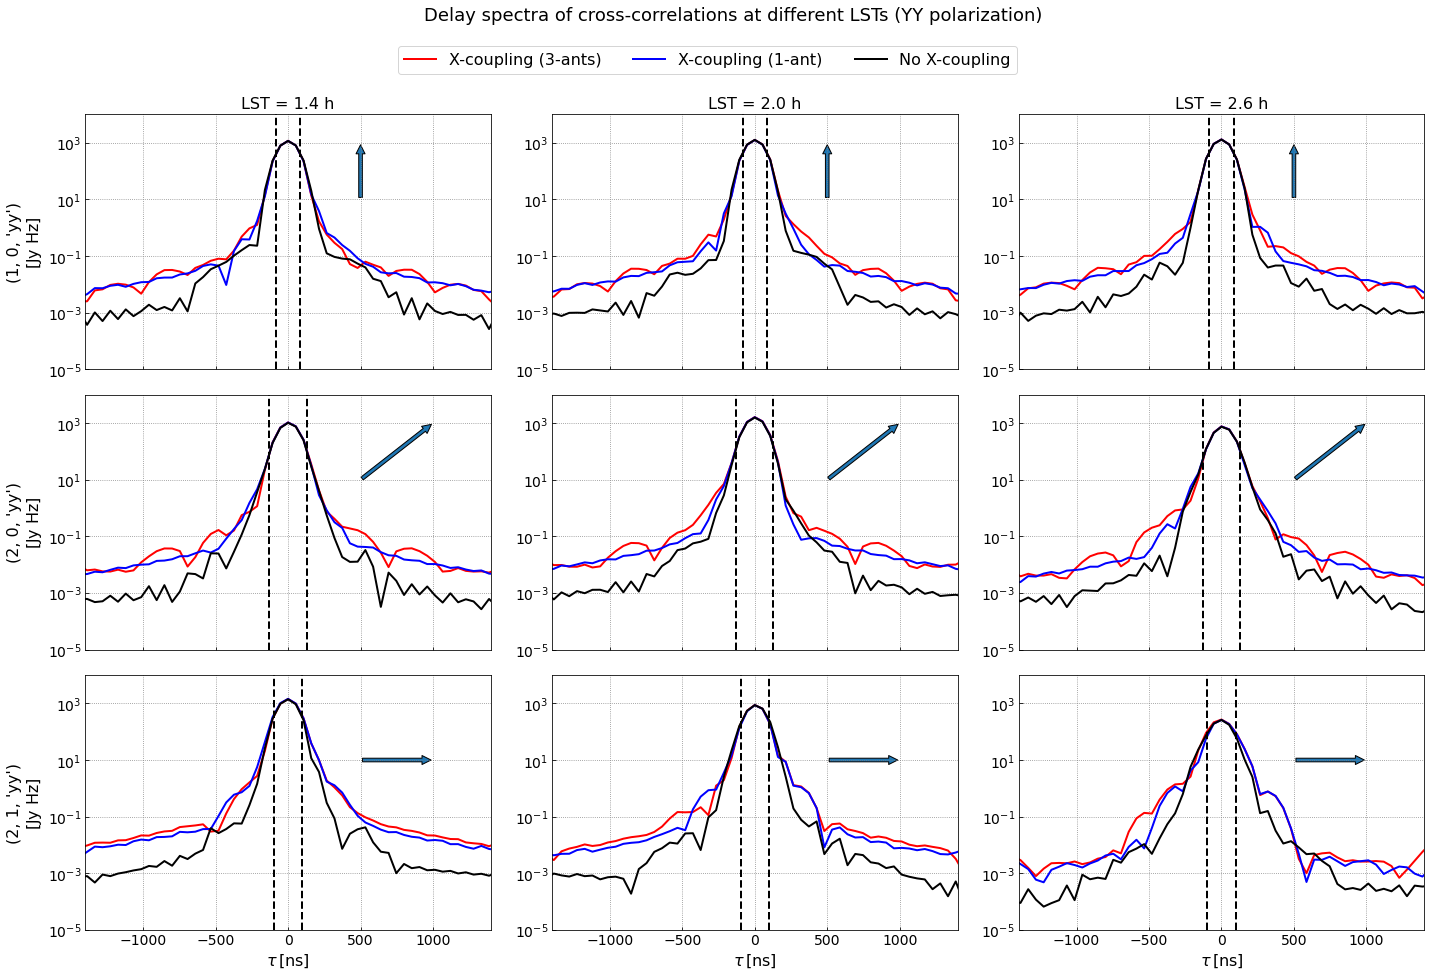

In [17]:
delayspec_slice_plotter(cc3_data,cc1_data,legacy_data,cross_list[3:],bl_length[3:],lst_slice,lst_idx,
                        r'Delay spectra of cross-correlations at different LSTs (YY polarization)',1.e-5,1.e4)